# Train and Apply Models

In [1]:
from ML.model_training import (
    random_train_test_split,
    omit_patient_video,
    train_random_forest,
    train_knn,
    omit_patient,
    train_knn_regressor,
    train_lstm,
    single_user_split,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import math, re, itertools
from ML import utils
import sys
from IPython.display import clear_output
from scipy.stats import pearsonr

## LOSO KNN Regressor

In [9]:
X_train, X_test, arousal_train, arousal_test = single_user_split(target="arousal", k_holdouts=2)

Generate all subsets of columns for parameters.

In [10]:
features = utils.important_features_list(
    "datasets/USE_feature_importance/dreamer_feature_importance_arousal.csv"
)
unique = []
for i in range(1, len(features)):
    unique.append(features[:i])

print("Unique:", unique)
print(len(unique))

Unique: [['T8_T7_gamma_ra'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha', 'FC6_FC5_gamma_ra'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha', 'FC6_FC5_gamma_ra', 'O1_gamma'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha', 'FC6_FC5_gamma_ra', 'O1_gamma', 'AF4_AF3_gamma_ra'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha', 'FC6_FC5_gamma_ra', 'O1_gamma', 'AF4_AF3_gamma_ra', 'FC6_FC5

Train KNN to predict arousal.

[██████████████████████████████] 49/49 (100.0%)
0.5024390243902439
Best: index=48 size=48 | PCC=-0.022694 | R2=-3.813945 | MAE=0.478049 | RMSE=0.796333 | K=51Best: index=48 size=48 | PCC=-0.022694 | R2=-3.813945 | MAE=0.478049 | RMSE=0.796333 | K=51


<Axes: xlabel='y_true', ylabel='y_pred'>

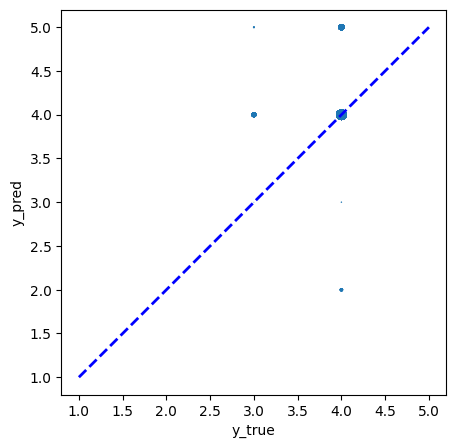

In [11]:
def safe_pcc(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if np.std(y_true) == 0 or np.std(y_pred) == 0:
        return float("nan")
    return float(np.corrcoef(y_true, y_pred)[0, 1])


best_mae = float("inf")
best_model = None
best_keep = None
best_n = None


bar_len = 30


def render(bar_str: str, status_str: str, curr):
    clear_output(wait=True)
    print(bar_str)
    print(curr)
    print(status_str, end="")
    sys.stdout.flush()


start_at = 40

total_full = len(unique)
iter_unique = unique[start_at - 1 :]

status = f"Best: index= size= | " f"acc= | f1= | prec= | rec= | K="

results = []
for idx, keep in enumerate(iter_unique, start_at):
    filled = int(bar_len * idx / total_full) if total_full else 0
    bar = "█" * filled + "-" * (bar_len - filled)
    pct = (idx / total_full * 100) if total_full else 100
    bar_str = f"[{bar}] {idx}/{total_full} ({pct:5.1f}%)"

    X_train_sub = X_train.loc[:, keep]
    X_test_sub = X_test.loc[:, keep]

    for n in [1, 9, 21, 51]:
        knn, X_test_eval, y_test_eval = train_knn(
            X_train_sub, X_test_sub, arousal_train, arousal_test, neighbors=n
        )
        arousal_pred = knn.predict(X_test_eval)

        r2 = r2_score(y_test_eval, arousal_pred)
        mae = mean_absolute_error(y_test_eval, arousal_pred)
        mse = mean_squared_error(y_test_eval, arousal_pred)
        rmse = math.sqrt(mse)
        pcc = safe_pcc(y_test_eval, arousal_pred)

        if mae < best_mae:
            best_mae = mae
            best_model = knn
            best_keep = keep
            best_n = n
            status = (
                f"Best: index={idx} size={len(keep)} | "
                f"PCC={pcc:.6f} | R2={r2:.6f} | MAE={mae:.6f} | RMSE={rmse:.6f} | K={best_n}"
            )

    render(bar_str, status, mae)
render(bar_str, status, mae)

print(status)
utils.plot_regressor_accuracy(y_test_eval.to_list(), arousal_pred)

## LSTM Single User LOO (per trial)

In [16]:
X_train, X_test, arousal_train, arousal_test = single_user_split(
    target="arousal", k_holdouts=1
)
arousal_train = pd.Series(
    np.where(arousal_train > 3, "high", "low"),
    index=arousal_train.index,
    dtype="string",
)
arousal_test = pd.Series(
    np.where(arousal_test > 3, "high", "low"),
    index=arousal_test.index,
    dtype="string",
)

def balance(X, y, seed=5):
    c = y.value_counts()
    if c.get("high", 0) == c.get("low", 0):
        return X.reset_index(drop=True), y.reset_index(drop=True)
    maj = c.idxmax()
    m = c.min()
    keep = y[y != maj].index.union(y[y == maj].sample(m, random_state=seed).index)
    return X.loc[keep].reset_index(drop=True), y.loc[keep].reset_index(drop=True)


X_train, arousal_train = balance(X_train, arousal_train, seed=5)
X_test, arousal_test = balance(X_test, arousal_test, seed=5)

print("arousal_train counts:\n", arousal_train.value_counts(dropna=False))
print("arousal_test counts:\n", arousal_test.value_counts(dropna=False))

arousal_train counts:
 low     717
high    717
Name: count, dtype: Int64
arousal_test counts:
 low    47
Name: count, dtype: Int64


In [18]:
best_model = None
best_acc = 0
best_keep = None

best_lr = 0
best_f1 = 0
bar_len = 30


def render(bar_str: str, status_str: str, curr):
    print(bar_str)
    print(curr)
    print(status_str, end="")
    sys.stdout.flush()


start_at = 49

total_full = len(unique)
iter_unique = unique[start_at - 1 :]

status = f"Best: index= size= | " f"acc= | f1= | prec= | rec="

results = []
for idx, keep in enumerate(iter_unique, start_at):
    filled = int(bar_len * idx / total_full) if total_full else 0
    bar = "█" * filled + "-" * (bar_len - filled)
    pct = (idx / total_full * 100) if total_full else 100
    bar_str = f"[{bar}] {idx}/{total_full} ({pct:5.1f}%)"

    X_train_sub = X_train.loc[:, keep]
    X_test_sub = X_test.loc[:, keep]

    n_low = (arousal_train == "low").sum()
    n_high = (arousal_train == "high").sum()
    for lr in [0.0001, 0.001, 0.01]:
        for e in [10, 15, 20, 30]:
            lstm, X_test_eval, y_test_eval = train_lstm(
                X_train_sub, X_test_sub, arousal_train, arousal_test, lr=lr, epochs=e, units=200, batch_size=256
            )
            y_prob = lstm.predict(X_test_eval).ravel()
            arousal_pred = (y_prob >= 0.5).astype(int)

            acc = accuracy_score(y_test_eval, arousal_pred)
            f1 = f1_score(y_test_eval, arousal_pred, average="weighted")
            prec = precision_score(y_test_eval, arousal_pred, average="weighted")
            # rec = recall_score(y_test_eval, arousal_pred, average="weighted")

            if f1 > best_f1:
                best_acc = acc
                best_model = lstm
                best_keep = keep
                best_lr = lr
                best_e = e
                best_f1 = f1
                best_arousal_pred = arousal_pred
                status = (
                    f"Best: index={idx} size={len(keep)} | "
                    f"acc={acc:.6f} | f1={f1:.6f} | prec={prec:.6f} | lr={best_lr} | epochs={best_e}"
                )
                print(status)

print("\nConfusion Matrix (pooled):")
print(confusion_matrix(y_test_eval, best_arousal_pred))

print("\nClassification Report (pooled):")
print(classification_report(y_test_eval, best_arousal_pred, zero_division=0))

print(status)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Best: index=49 size=49 | acc=0.872340 | f1=0.931818 | prec=1.000000 | lr=0.0001 | epochs=10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Best: index=49 size=49 | acc=0.957447 | f1=0.978261 | prec=1.000000 | lr=0.001 | epochs=10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

Confusion Matrix (pooled):
[[45  2]
 [ 0  0]]

Classification Report (pooled):
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        47
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96        47
   macro avg       0.50      0.48      0.49        

In [24]:
acc_list = []
f1_list = []
prec_list = []
rec_list = []
n_list = []

num_folds = 50
y_test_full = []
y_pred_full = []

for fold in range(num_folds):

    # while True:
    X_train, X_test, arousal_train, arousal_test = single_user_split(
        target="arousal", k_holdouts=1
    )
    arousal_train = pd.Series(
        np.where(arousal_train > 3, "high", "low"),
        index=arousal_train.index,
        dtype="string",
    )
    arousal_test = pd.Series(
        np.where(arousal_test > 3, "high", "low"),
        index=arousal_test.index,
        dtype="string",
    )

    # c = arousal_test.value_counts()
    # if c.get("high", 0) == 0 or c.get("low", 0) == 0:
    #     continue


    X_train, arousal_train = balance(X_train, arousal_train)
    X_test, arousal_test = balance(X_test, arousal_test)
    # break

    print("arousal_train counts:\n", arousal_train.value_counts(dropna=False))
    print("arousal_test counts:\n", arousal_test.value_counts(dropna=False))


    clf, X_test_eval, y_test_eval = train_lstm(
        X_train, X_test, arousal_train, arousal_test, lr=best_lr, epochs=best_e
    )

    y_prob = clf.predict(X_test_eval).ravel()
    y_pred = (y_prob >= 0.5).astype(int)


    acc = accuracy_score(y_test_eval, y_pred)
    f1w = f1_score(y_test_eval, y_pred, average="weighted", zero_division=0)
    prec = precision_score(y_test_eval, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test_eval, y_pred, average="weighted", zero_division=0)

    acc_list.append(float(acc))
    print(acc)
    f1_list.append(float(f1w))
    prec_list.append(float(prec))
    rec_list.append(float(rec))

    y_test_full.extend(y_test_eval)
    y_pred_full.extend(y_pred.tolist() if hasattr(y_pred, "tolist") else list(y_pred))

# averages across folds
avg_acc = float(np.mean(acc_list)) if acc_list else float("nan")
avg_f1 = float(np.mean(f1_list)) if f1_list else float("nan")
avg_prec = float(np.mean(prec_list)) if prec_list else float("nan")
avg_rec = float(np.mean(rec_list)) if rec_list else float("nan")

final_n = n_list[0] if len(n_list) > 0 else "N/A"

print("LSTM Classification Performance (cross-subject folds)")
print("---------------------------------------------------")
print(f"N_Neighbors: {final_n}")
print(f"Accuracy: {avg_acc:.4f}")
print(f"F1: {avg_f1:.4f}")
print(f"Precision: {avg_prec:.4f}")
print(f"Recall: {avg_rec:.4f}")

print("\nBest feature subset")
print("-------------------")
print(f"Count: {len(best_keep)}")
wrap = 4
for i in range(0, len(best_keep), wrap):
    print(", ".join(best_keep[i : i + wrap]))

print("\nConfusion Matrix (pooled):")
print(confusion_matrix(y_test_full, y_pred_full))

print("\nClassification Report (pooled):")
print(classification_report(y_test_full, y_pred_full, zero_division=0))

arousal_train counts:
 low     705
high    705
Name: count, dtype: Int64
arousal_test counts:
 low    67
Name: count, dtype: Int64
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0.34328358208955223
arousal_train counts:
 low     700
high    700
Name: count, dtype: Int64
arousal_test counts:
 low    95
Name: count, dtype: Int64
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0.8842105263157894
arousal_train counts:
 low     563
high    563
Name: count, dtype: Int64
arousal_test counts:
 low    89
Name: count, dtype: Int64
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0.2808988764044944
arousal_train counts:
 low     514
high    514
Name: count, dtype: Int64
arousal_test counts:
 high    82
Name: count, dtype: Int64
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
0.24390243902439024
arousal_train counts:
 low     577
high    577
Name: count, dtype: Int64
arousal_test counts:
 low    153
Name: count, dtype: Int64
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0.9738562091503268
arousal_train counts:
 low     468
high    468
Name: cou

### Train RF Regressor

In [23]:
best_model = None
best_mae = math.inf
best_keep = None
best_metrics = {
    "PCC": 0.0,
    "MSE": math.inf,
    "RMSE": math.inf,
    "MAE": math.inf,
    "size": 0,
}

best_n = 1
# n = 1

bar_len = 30


def safe_pcc(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float).ravel()
    yp = np.asarray(y_pred, dtype=float).ravel()
    if yt.size < 2 or np.std(yt) == 0 or np.std(yp) == 0:
        return 0.0
    return float(np.corrcoef(yt, yp)[0, 1])


def render(bar_str: str, status_str: str, curr_mae):
    clear_output(wait=True)
    print(bar_str)
    print(curr_mae)
    print(status_str, end="")
    sys.stdout.flush()


status = "Best: size=0 | PCC=0.0000 | MSE=∞ | RMSE=∞ | MAE=∞"

start_at = 49

total_full = len(unique)
iter_unique = unique[start_at - 1 :]

for idx, keep in enumerate(iter_unique, start_at):
    filled = int(bar_len * idx / total_full) if total_full else 0
    bar = "█" * filled + "-" * (bar_len - filled)
    pct = (idx / total_full * 100) if total_full else 100
    bar_str = f"[{bar}] {idx}/{total_full} ({pct:5.1f}%)"

    X_train_sub = X_train.loc[:, keep]
    X_test_sub = X_test.loc[:, keep]

    rf, X_test_eval, y_test_eval = train_random_forest(
        X_train_sub, X_test_sub, arousal_train, arousal_test
    )

    arousal_pred = rf.predict(X_test_eval)
    mse = mean_squared_error(y_test_eval, arousal_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_eval, arousal_pred)
    pcc = safe_pcc(y_test_eval, arousal_pred)

    if mae < best_mae:
        best_mae = mae
        best_model = rf
        best_keep = keep
        best_n = n
        best_metrics = {
            "PCC": pcc,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "size": len(keep),
        }
        status = (
            f"Best: index={idx} size={len(keep)} | "
            f"PCC={pcc:.4f} | MSE={mse:.6f} | RMSE={rmse:.6f} | MAE={mae:.6f}"
        )

    render(bar_str, status, mae)
render(bar_str, status, mae)
# 40076!! low mse
# 40418!! low mae

ValueError: could not convert string to float: 'low'

**Hyperparameter Tuning**

Random Forest Regression Performance (10 random splits)
--------------------------------------------
PCC:  0.8427 (avg p=0)
R²:   0.6994
MAE:  0.208063
MSE:  0.123219
RMSE: 0.351025

Best feature subset
-------------------
Count: 49
T8_T7_gamma_ra, T8_T7_gamma_da, O2_alpha, FC5_gamma
F8_alpha, P8_alpha, O1_alpha, FC6_FC5_gamma_ra
O1_gamma, AF4_AF3_gamma_ra, FC6_FC5_gamma_da, AF4_AF3_gamma_da
T7_gamma, F8_theta, P8_P7_gamma_da, P8_theta
F3_gamma, F8_F7_alpha_ra, P8_P7_gamma_ra, F8_gamma
FC5_alpha, O2_gamma, F8_F7_delta_da, FC6_gamma
F8_F7_theta_ra, FC6_alpha, F8_F7_delta_ra, AF4_alpha
F8_F7_theta_da, F8_F7_alpha_da, O1_theta, AF4_gamma
T8_alpha, F4_F3_gamma_ra, O2_O1_delta_ra, P8_gamma
O2_theta, O2_O1_delta_da, F7_gamma, AF3_gamma
P7_alpha, F4_alpha, F4_F3_alpha_ra, T8_T7_alpha_da
T8_T7_alpha_ra, F3_alpha, T8_theta, F4_F3_alpha_da
FC5_theta


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


<Axes: xlabel='y_true', ylabel='y_pred'>

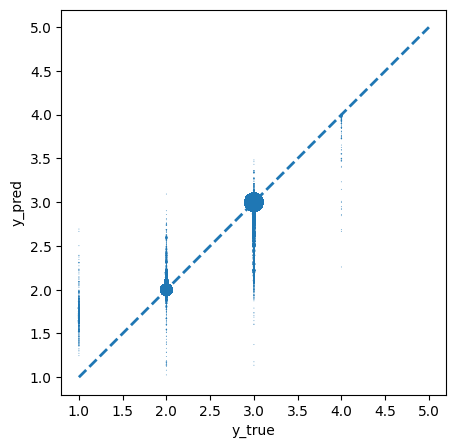

In [ ]:
pcc_list = []
pval_list = []
r2_list = []
mae_list = []
mse_list = []
rmse_list = []
n_list = []

best_cross_val_mae = math.inf

num_folds = 1

for fold in range(num_folds):
    X_train, X_test, arousal_train, arousal_test = omit_patient_video(
        target="arousal",
    )

    X_train_sub = X_train.loc[:, best_keep]
    X_test_sub = X_test.loc[:, best_keep]

    # rf, X_test_eval, y_test_eval = train_random_forest(
    #     X_train_sub,
    #     X_test_sub,
    #     arousal_train,
    #     arousal_test
    # )

    y_pred = rf.predict(X_test_eval)

    r2 = r2_score(y_test_eval, y_pred)
    mae = mean_absolute_error(y_test_eval, y_pred)
    mse = mean_squared_error(y_test_eval, y_pred)
    rmse = float(np.sqrt(mse))

    try:
        from scipy.stats import pearsonr

        pcc, pval = pearsonr(
            np.asarray(y_test_eval).ravel(), np.asarray(y_pred).ravel()
        )
    except Exception:
        yt = np.asarray(y_test_eval, dtype=float).ravel()
        yp = np.asarray(y_pred, dtype=float).ravel()
        if yt.size < 2 or np.std(yt) == 0 or np.std(yp) == 0:
            pcc, pval = 0.0, float("nan")
        else:
            pcc = float(np.corrcoef(yt, yp)[0, 1])
            pval = float("nan")

    n_used = getattr(knn, "n_neighbors", None)
    if n_used is None:
        if "best_n" in globals():
            n_used = best_n
        else:
            n_used = "N/A"

    pcc_list.append(float(pcc))
    pval_list.append(float(pval))
    r2_list.append(float(r2))
    mae_list.append(float(mae))
    mse_list.append(float(mse))
    rmse_list.append(float(rmse))
    n_list.append(n_used)

avg_pcc = float(np.mean(pcc_list))
avg_pval = float(np.mean(pval_list))
avg_r2 = float(np.mean(r2_list))
avg_mae = float(np.mean(mae_list))
avg_mse = float(np.mean(mse_list))
avg_rmse = float(np.mean(rmse_list))

if len(n_list) > 0:
    final_n = n_list[0]
else:
    final_n = "N/A"

print("Random Forest Regression Performance (10 random splits)")
print("--------------------------------------------")
print(f"PCC:  {avg_pcc:.4f} (avg p={avg_pval:.3g})")
print(f"R²:   {avg_r2:.4f}")
print(f"MAE:  {avg_mae:.6f}")
print(f"MSE:  {avg_mse:.6f}")
print(f"RMSE: {avg_rmse:.6f}")

print("\nBest feature subset")
print("-------------------")
print(f"Count: {len(best_keep)}")
wrap = 4
for i in range(0, len(best_keep), wrap):
    print(", ".join(best_keep[i : i + wrap]))

utils.plot_regressor_accuracy(y_test_eval.to_list(), y_pred)